<a href="https://colab.research.google.com/github/abishekP101/TimeSeriesForecasting/blob/main/TimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip  install utilsforecast

In [7]:
!pip install statsforecast

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utilsforecast.plotting import plot_series
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import *

import warnings
warnings.filterwarnings('ignore')


In [9]:
!pip install ydata_profiling
from ydata_profiling import ProfileReport

In [10]:
df = pd.read_csv('daily_sales_french_bakery.csv' , parse_dates=['ds'])


In [11]:
df.isnull().sum()

,0
unique_id,0
ds,0
y,0
unit_price,0


In [12]:
pf = ProfileReport(df)

In [13]:
# pf

In [14]:
df.head()

,unique_id,ds,y,unit_price
0,12 MACARON,2022-07-13,10.0,10.0
1,12 MACARON,2022-07-14,0.0,10.0
2,12 MACARON,2022-07-15,0.0,10.0
3,12 MACARON,2022-07-16,10.0,10.0
4,12 MACARON,2022-07-17,30.0,10.0


In [15]:
df = df.groupby('unique_id').filter(lambda x: len(x) >= 28)
df = df.drop(['unit_price'], axis=1)
df.head()

,unique_id,ds,y
0,12 MACARON,2022-07-13,10.0
1,12 MACARON,2022-07-14,0.0
2,12 MACARON,2022-07-15,0.0
3,12 MACARON,2022-07-16,10.0
4,12 MACARON,2022-07-17,30.0


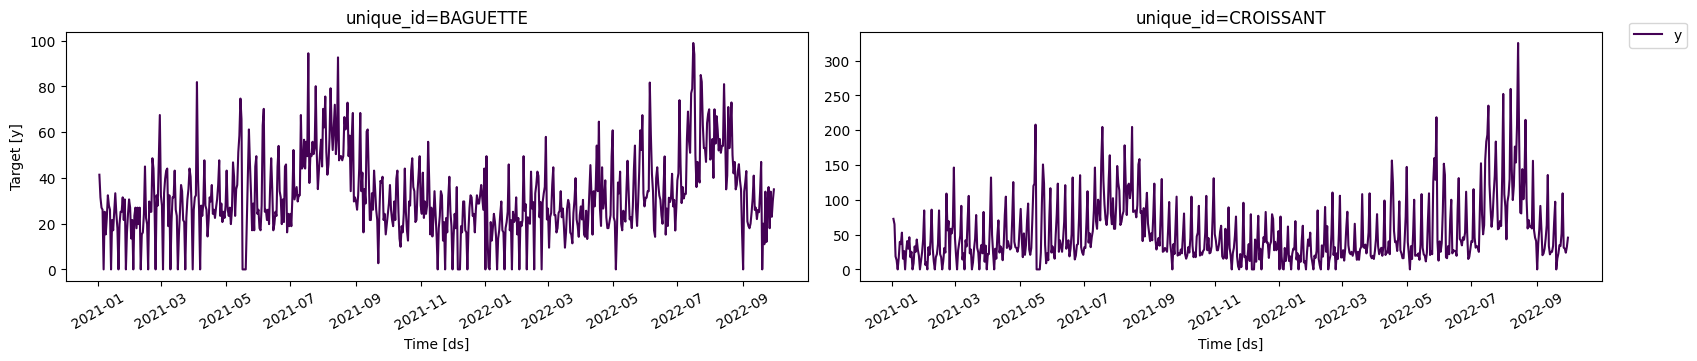

In [16]:
plot_series(df=df , ids=["BAGUETTE" , "CROISSANT"] , palette="viridis")

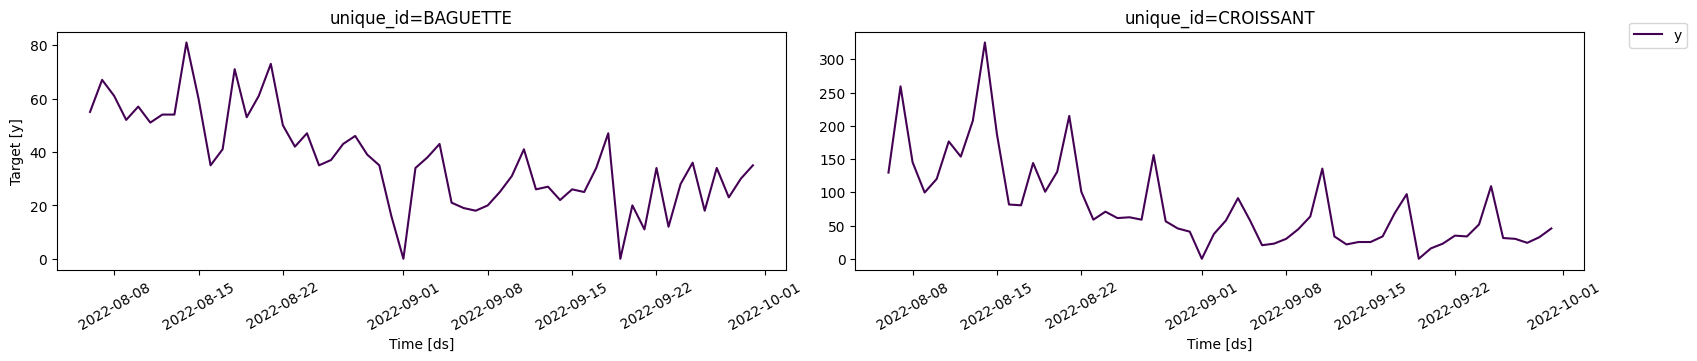

In [17]:
plot_series(df=df , ids=["BAGUETTE" , "CROISSANT"], max_insample_length=56 , palette="viridis")

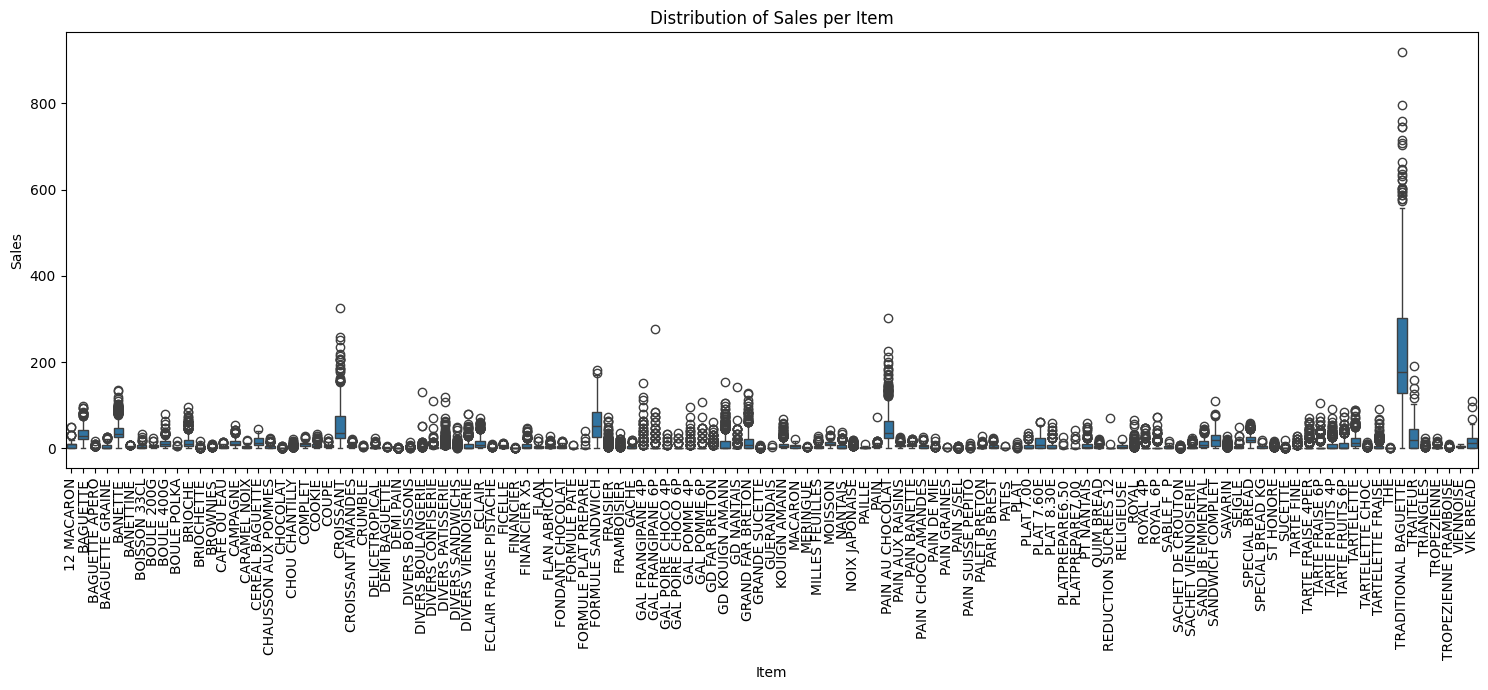

In [18]:
plt.figure(figsize=(15, 7))
sns.boxplot(data=df, x='unique_id', y='y')
plt.xticks(rotation=90)
plt.title('Distribution of Sales per Item')
plt.xlabel('Item')
plt.ylabel('Sales')
plt.tight_layout()
plt.show()

BASELINE MODEL

In [19]:
from statsforecast import StatsForecast
from statsforecast.models import Naive , HistoricAverage , WindowAverage , SeasonalNaive

In [20]:
horizon = 7

models = [
    Naive(),
    HistoricAverage(),
    WindowAverage(window_size=7),
    SeasonalNaive(season_length=7)
]
sf = StatsForecast(models = models , freq="D")
sf.fit(df=df)
preds = sf.predict(h=horizon)


In [21]:
preds.head()

,unique_id,ds,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,12 MACARON,2022-09-29,10.0,8.974359,2.857143,0.0
1,12 MACARON,2022-09-30,10.0,8.974359,2.857143,0.0
2,12 MACARON,2022-10-01,10.0,8.974359,2.857143,10.0
3,12 MACARON,2022-10-02,10.0,8.974359,2.857143,0.0
4,12 MACARON,2022-10-03,10.0,8.974359,2.857143,0.0


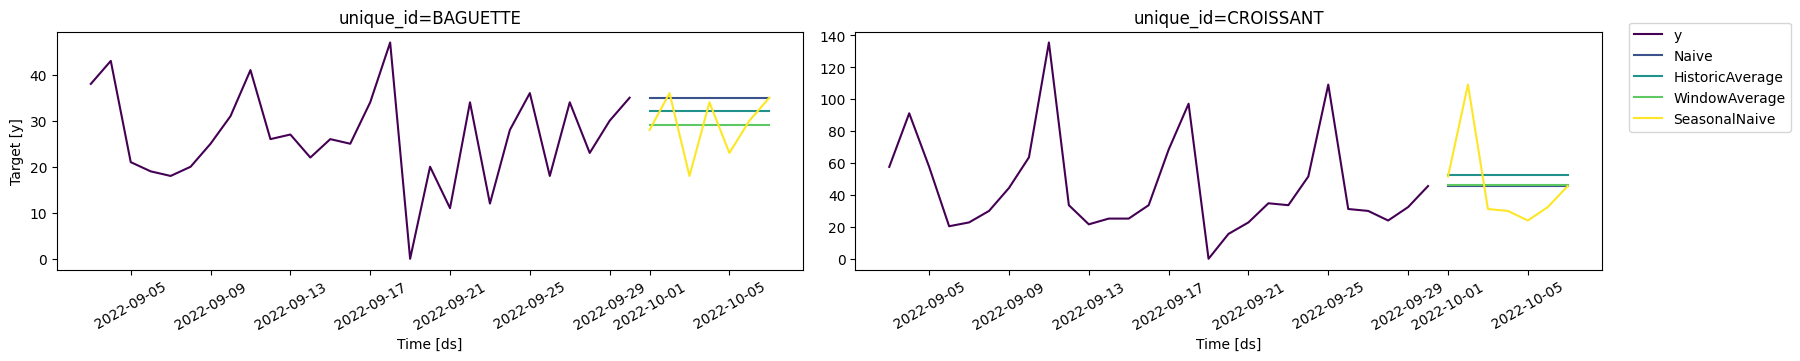

In [22]:
plot_series(
    df = df,
    forecasts_df=preds,
    ids=["BAGUETTE" , "CROISSANT"],
    max_insample_length=28,
    palette="viridis"
)

In [23]:
test = df.groupby('unique_id').tail(7)
train = df.drop(test.index).reset_index(drop=True)

In [24]:
sf.fit(df=train)
preds = sf.predict(h=horizon)
eval_df = pd.merge(test , preds , 'left' , ['ds' , 'unique_id'])

In [25]:
evaluation = evaluate(
    eval_df,
    metrics=[mae],
)
evaluation.head()

,unique_id,metric,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,12 MACARON,mae,2.857143,6.961771,3.469388,4.285714
1,BAGUETTE,mae,17.142857,5.455193,7.877551,12.571429
2,BAGUETTE APERO,mae,0.000000,0.537572,0.642857,0.642857
3,BAGUETTE GRAINE,mae,9.800000,4.612271,2.942857,0.200000
4,BANETTE,mae,1.314286,5.421984,6.008163,7.885714


In [26]:
evaluation = evaluation.drop(['unique_id'] , axis=1).groupby('metric').mean().reset_index()

In [27]:

evaluation

,metric,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,mae,6.107556,5.228439,5.011663,4.613636


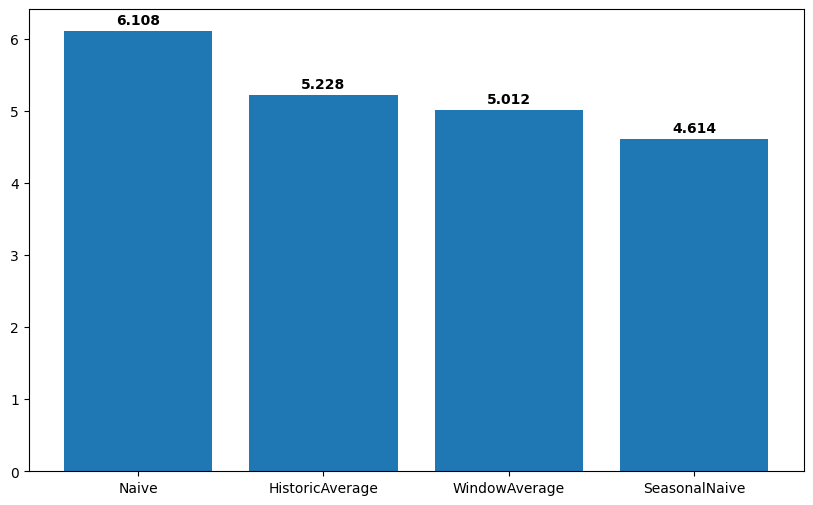

In [28]:
methods = evaluation.columns[1:].tolist()
values = evaluation.iloc[0, 1:].tolist()

plt.figure(figsize=(10 , 6))
bars = plt.bar(methods , values)

for bar ,value in zip(bars , values):
  plt.text(bar.get_x() + bar.get_width() / 2 , bar.get_height()+0.05,
           f'{value:.3f}' ,va='bottom', ha='center' , fontweight='bold')

AUTOARIMA MODEL

In [29]:
from statsforecast.models import AutoARIMA

unique_ids = ["BAGUETTE" , "CROISSANT"]
small_train = train[train["unique_id"].isin(unique_ids)]
small_test  = test[test["unique_id"].isin(unique_ids)]


models = [
    AutoARIMA(seasonal=False , alias="ARIMA"),
    AutoARIMA(season_length=7 , alias="SARIMA")
]

sf = StatsForecast(models=models , freq="D")
sf.fit(df=small_train)
arima_preds = sf.predict(h=horizon)


arima_eval_df = pd.merge(arima_preds , eval_df , 'inner' , ['ds' , 'unique_id'])
arima_eval = evaluate(
    arima_eval_df,
    metrics=[mae],
)
arima_eval

,unique_id,metric,ARIMA,SARIMA,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,BAGUETTE,mae,9.353153,7.449083,17.142857,5.455193,7.877551,12.571429
1,CROISSANT,mae,14.565395,10.359143,17.485714,22.618934,18.244898,12.857143


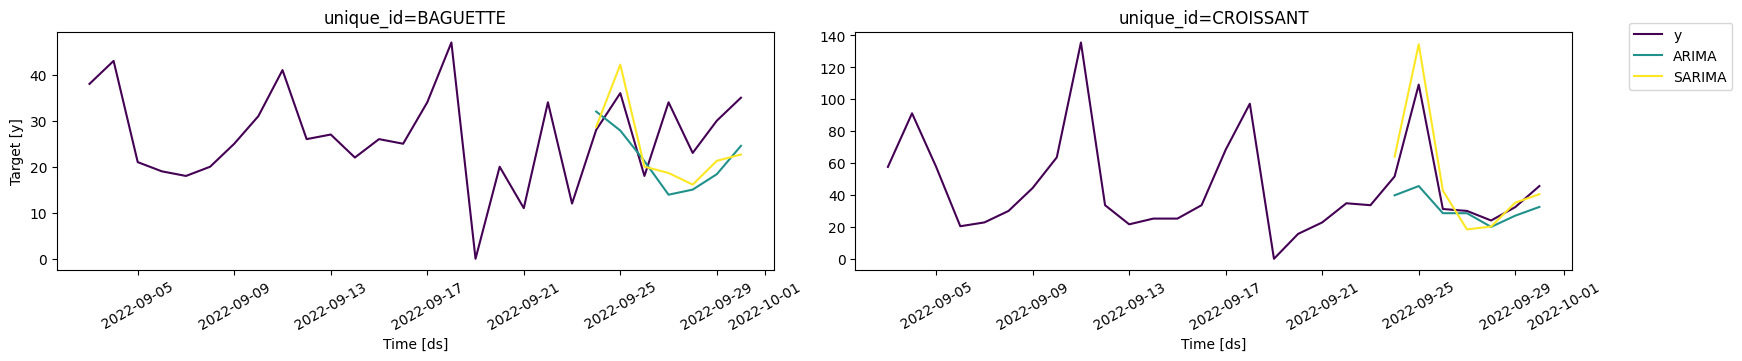

In [30]:
plot_series(
    df=df,
    forecasts_df= arima_preds,
    ids=["BAGUETTE" , "CROISSANT"],
    max_insample_length=28,
    palette="viridis"
)

In [31]:
small_df = df[df["unique_id"].isin(unique_ids)]
models = [
    SeasonalNaive(season_length=7),
    AutoARIMA(seasonal=False , alias="ARIMA"),
    AutoARIMA(season_length=7 , alias="SARIMA"),
]
sf = StatsForecast(models=models , freq="D")
cv_df = sf.cross_validation(
    h= horizon,
    df= small_df,
    n_windows=8,
    step_size=horizon,
    refit=True,
)
cv_df.head()

,unique_id,ds,cutoff,y,SeasonalNaive,ARIMA,SARIMA
0,BAGUETTE,2022-08-06,2022-08-05,55.0,68.0,71.355196,71.584713
1,BAGUETTE,2022-08-07,2022-08-05,67.0,70.0,70.337980,78.458883
2,BAGUETTE,2022-08-08,2022-08-05,61.0,48.0,61.195004,57.001732
3,BAGUETTE,2022-08-09,2022-08-05,52.0,49.0,52.649013,49.401144
4,BAGUETTE,2022-08-10,2022-08-05,57.0,57.0,47.785876,49.725278


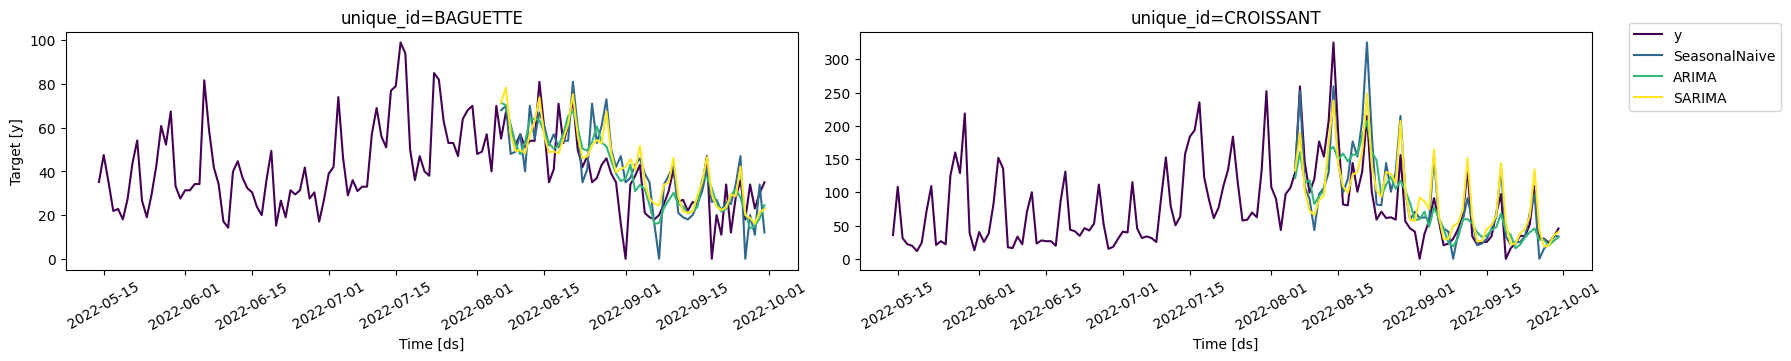

In [32]:
plot_series(
    df=small_df,
    forecasts_df = cv_df.drop(["y" , "cutoff"] , axis=1),
    ids=["BAGUETTE" , "CROISSANT"],
    max_insample_length=140,
    palette="viridis"
)

In [33]:
cv_eval = evaluate(
    cv_df.drop(["cutoff"] , axis=1),
    metrics=[mae],
)
cv_eval = cv_eval.drop(["unique_id"] , axis=1).groupby("metric").mean().reset_index()
cv_eval


,metric,SeasonalNaive,ARIMA,SARIMA
0,mae,21.117857,21.17093,19.281296


## FORECASTING USING EXOGENOUS FEATURES

In [34]:
df = pd.read_csv('daily_sales_french_bakery.csv' , parse_dates=['ds'])
df = df.groupby('unique_id').filter(lambda x: len(x) >= 28)
df.head()

,unique_id,ds,y,unit_price
0,12 MACARON,2022-07-13,10.0,10.0
1,12 MACARON,2022-07-14,0.0,10.0
2,12 MACARON,2022-07-15,0.0,10.0
3,12 MACARON,2022-07-16,10.0,10.0
4,12 MACARON,2022-07-17,30.0,10.0


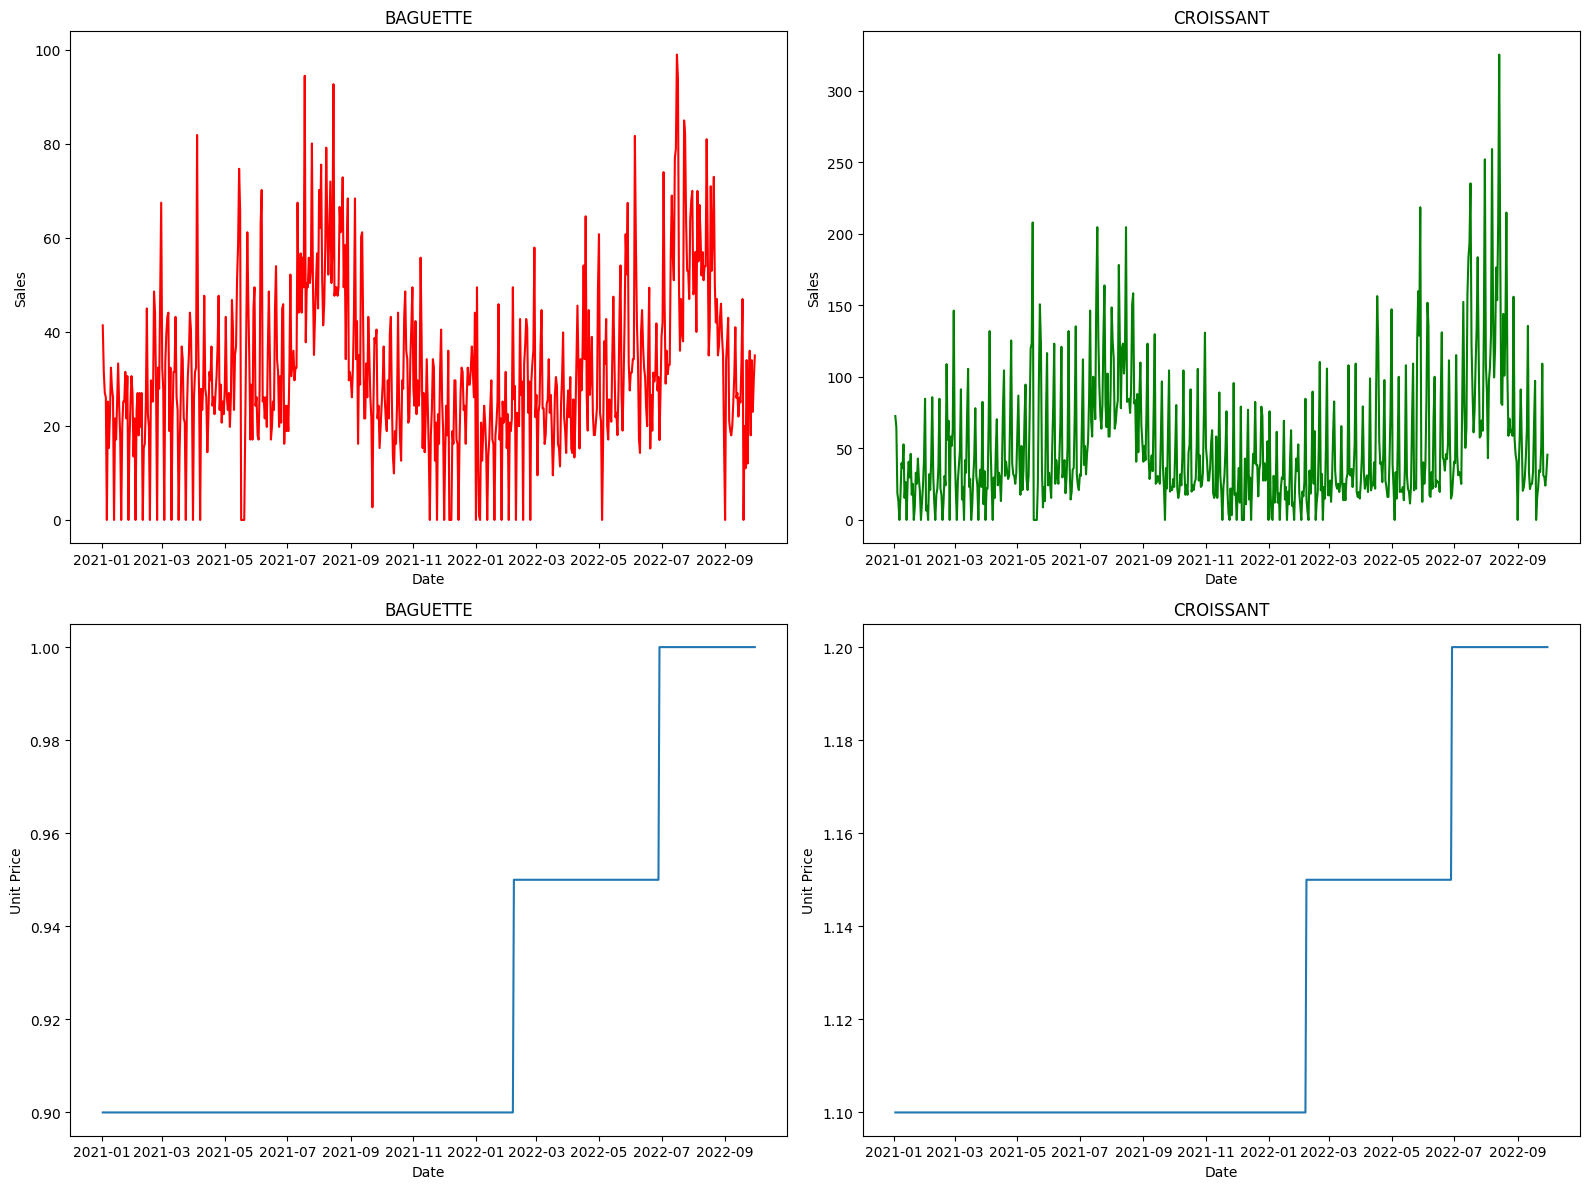

In [35]:
baguette_plot_df = df[df["unique_id"]=="BAGUETTE"]
croissant_plot_df = df[df["unique_id"]=="CROISSANT"]

fig , ((ax1 , ax2),(ax3, ax4)) = plt.subplots(2, 2 , figsize=(16 , 12))
ax1.plot(baguette_plot_df["ds"] , baguette_plot_df["y"] , color="red")
ax1.set_xlabel("Date")
ax1.set_ylabel("Sales")
ax1.set_title("BAGUETTE")
ax2.plot(croissant_plot_df["ds"] , croissant_plot_df["y"] , color="green")
ax2.set_title("CROISSANT")
ax2.set_xlabel("Date")
ax2.set_ylabel("Sales")
ax3.plot(baguette_plot_df["ds"] , baguette_plot_df["unit_price"])
ax3.set_title("BAGUETTE")
ax3.set_xlabel("Date")
ax3.set_ylabel("Unit Price")
ax4.plot(croissant_plot_df["ds"] , croissant_plot_df["unit_price"])
ax4.set_title("CROISSANT")
ax4.set_xlabel("Date")
ax4.set_ylabel("Unit Price")
plt.tight_layout()

In [36]:
unique_ids = ["BAGUETTE" , "CROISSANT"]
small_df = df[df["unique_id"].isin(unique_ids)]
test = small_df.groupby('unique_id').tail(7)
train = small_df.drop(test.index).reset_index(drop=True)

In [38]:
futr_exog_df = test.drop(["y"] , axis=1)
futr_exog_df.head()

,unique_id,ds,unit_price
714,BAGUETTE,2022-09-24,1.0
715,BAGUETTE,2022-09-25,1.0
716,BAGUETTE,2022-09-26,1.0
717,BAGUETTE,2022-09-27,1.0
718,BAGUETTE,2022-09-28,1.0


In [41]:
models = [
    AutoARIMA(season_length=7 , alias="SARIMA_exog")
]
sf = StatsForecast(models=models , freq="D")
sf.fit(df=train)

arima_exog_preds = sf.predict(h=horizon , X_df=futr_exog_df)

In [42]:
models = [
    AutoARIMA(season_length=7 , alias="SARIMA")
]
sf = StatsForecast(models=models , freq="D")
sf.fit(df=train.drop(['unit_price'] , axis=1))
arima_preds = sf.predict(h=horizon)

In [43]:
test_df = test.merge(arima_exog_preds , on=["unique_id","ds"] , how="left").merge(arima_preds , on=["unique_id" , "ds"] , how="left")

In [44]:
test_df

,unique_id,ds,y,unit_price,SARIMA_exog,SARIMA
0,BAGUETTE,2022-09-24,28.0,1.0,28.898898,28.657114
1,BAGUETTE,2022-09-25,36.0,1.0,42.513264,42.182373
2,BAGUETTE,2022-09-26,18.0,1.0,20.423976,20.013652
3,BAGUETTE,2022-09-27,34.0,1.0,19.066264,18.646490
4,BAGUETTE,2022-09-28,23.0,1.0,16.468885,16.114925
5,BAGUETTE,2022-09-29,30.0,1.0,21.656726,21.288019
6,BAGUETTE,2022-09-30,35.0,1.0,23.101235,22.660124
7,CROISSANT,2022-09-24,51.6,1.2,64.424926,64.011002
8,CROISSANT,2022-09-25,109.2,1.2,135.124207,134.488202
9,CROISSANT,2022-09-26,31.2,1.2,43.526109,42.735407


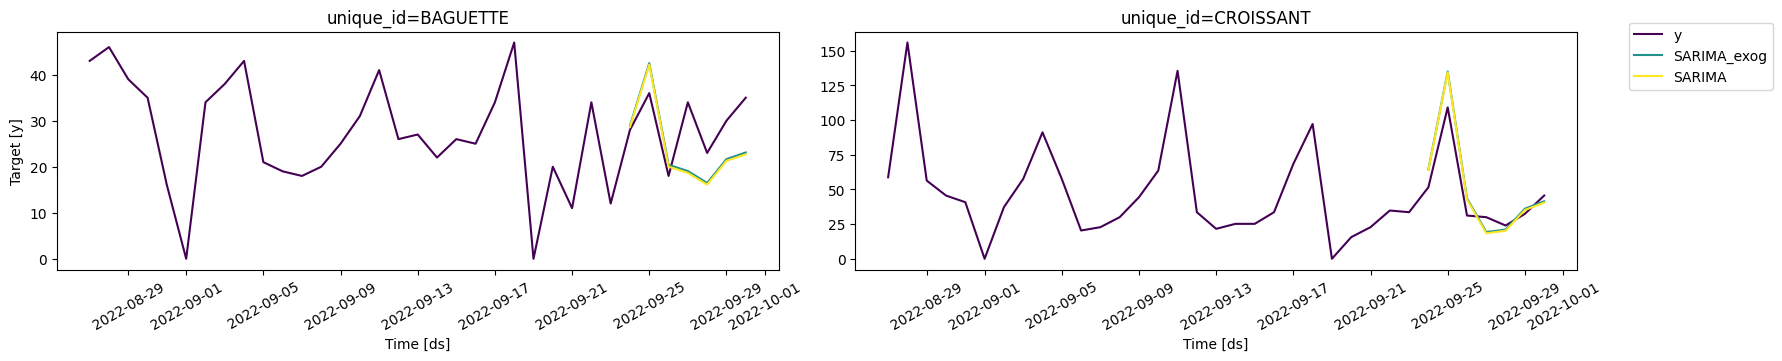

In [45]:
plot_series(
    df= train,
    forecasts_df = test_df,
    ids=['BAGUETTE' , 'CROISSANT'],
    max_insample_length=28,
    models=['SARIMA_exog' , 'SARIMA'],
    palette="viridis"
)

In [47]:
models = [
    AutoARIMA(season_length=7 , alias="SARIMA_exog")
]
sf = StatsForecast(models=models , freq="D")
cv_exog_df = sf.cross_validation(
    h= horizon,
    df= small_df,
    n_windows=8,
    step_size=horizon,
    refit=True,
)

cv_exog_df.head()



,unique_id,ds,cutoff,y,SARIMA_exog
0,BAGUETTE,2022-08-06,2022-08-05,55.0,71.511528
1,BAGUETTE,2022-08-07,2022-08-05,67.0,78.458054
2,BAGUETTE,2022-08-08,2022-08-05,61.0,57.062745
3,BAGUETTE,2022-08-09,2022-08-05,52.0,49.525901
4,BAGUETTE,2022-08-10,2022-08-05,57.0,49.485683


In [48]:
cv_exog_eval = evaluate(
    cv_exog_df.drop(['cutoff'] , axis=1),
    metrics=[mae],
)
cv_exog_eval = cv_exog_eval.drop(["unique_id"] , axis=1).groupby("metric").mean().reset_index()
cv_exog_eval


,metric,SARIMA_exog
0,mae,19.211687


## Creating features from timestamps

In [49]:
from functools import partial
from utilsforecast.feature_engineering import fourier , time_features , pipeline

In [51]:
features = [
    partial(fourier , season_length=7 , k=2),
    partial(time_features , features=['day' , "week" , 'month'])
]
small_exog_df , futr_exog_df = pipeline(df=small_df,features=features,
                                        freq="D" , h=horizon)

In [52]:
small_exog_df.head()

,unique_id,ds,y,unit_price,sin1_7,sin2_7,cos1_7,cos2_7,day,week,month
84,BAGUETTE,2021-01-02,41.4,0.9,0.781832,0.974928,0.623490,-0.222521,2,53,1
85,BAGUETTE,2021-01-03,31.5,0.9,0.974928,-0.433884,-0.222521,-0.900969,3,53,1
86,BAGUETTE,2021-01-04,27.0,0.9,0.433884,-0.781831,-0.900969,0.623490,4,1,1
87,BAGUETTE,2021-01-05,26.1,0.9,-0.433884,0.781832,-0.900969,0.623490,5,1,1
88,BAGUETTE,2021-01-06,0.0,0.9,-0.974928,0.433884,-0.222521,-0.900969,6,1,1


In [53]:
models = [
    AutoARIMA(season_length=7 , alias="SARIMA_exog")
]
sf = StatsForecast(models=models , freq="D")
cv_time_exog_df = sf.cross_validation(
    h=horizon,
    df=small_exog_df,
    n_windows=8,
    step_size=horizon,
    refit=True,
)
cv_time_exog_eval = evaluate(
    cv_time_exog_df.drop(['cutoff'] , axis=1),
    metrics=[mae],
)
cv_time_exog_eval = cv_time_exog_eval.drop(["unique_id"] , axis=1).groupby("metric").mean().reset_index()
cv_time_exog_eval


,metric,SARIMA_exog
0,mae,19.721581


In [66]:
unique_ids = ["BAGUETTE", "CROISSANT"]
small_df = df[df["unique_id"].isin(unique_ids)]
test = small_df.groupby("unique_id").tail(7)
train = small_df.drop(test.index).reset_index(drop=True)

In [67]:
train.head()

,unique_id,ds,y,unit_price
0,BAGUETTE,2021-01-02,41.4,0.9
1,BAGUETTE,2021-01-03,31.5,0.9
2,BAGUETTE,2021-01-04,27.0,0.9
3,BAGUETTE,2021-01-05,26.1,0.9
4,BAGUETTE,2021-01-06,0.0,0.9


In [68]:
models = [
    AutoARIMA(season_length=7),
]
sf = StatsForecast(models=models , freq="D")
sf.fit(df=train)
prob_preds = sf.predict(h=horizon , X_df=test.drop(["y"], axis=1), level=[80])

In [69]:
test_df  = test.merge(prob_preds , on=["unique_id" ,"ds"] , how="left")

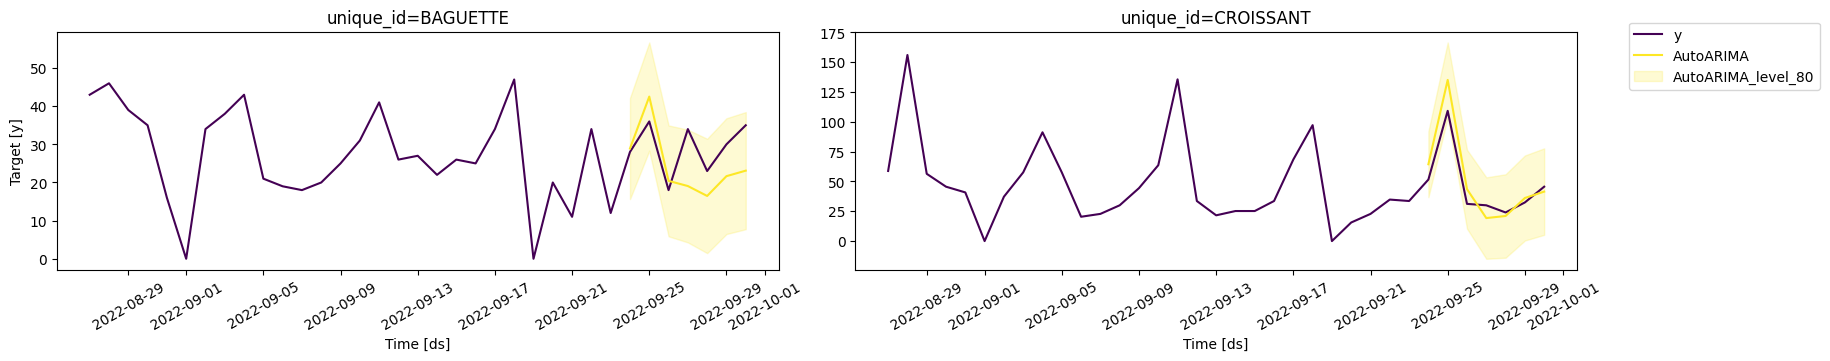

In [70]:
plot_series(
    df= train,
    forecasts_df = test_df,
    ids=['BAGUETTE' , 'CROISSANT'],
    max_insample_length=28,
    models=['AutoARIMA'],
    level=[80],
    palette="viridis"
)

In [72]:
models = [
    AutoARIMA(season_length=7)
]
sf = StatsForecast(models=models , freq="D")

cv_prob_df = sf.cross_validation(
    h=horizon,
    df=small_df,
    n_windows=8,
    step_size=horizon,
    refit=True,
    level=[80],
)


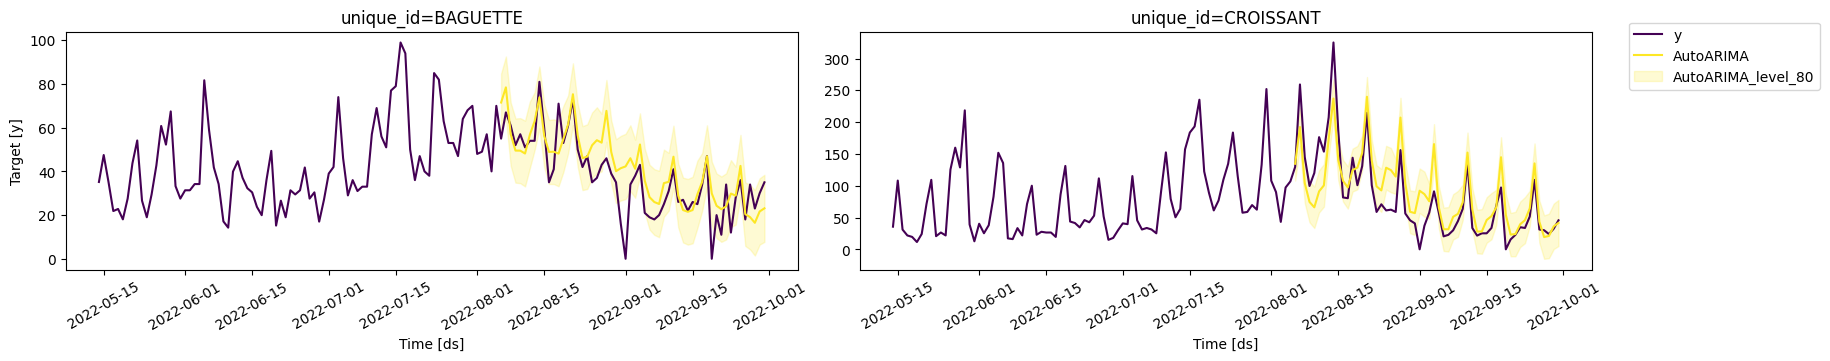

In [73]:
plot_series(
    df=small_df,
    forecasts_df = cv_prob_df.drop(["y" , "cutoff"] , axis=1),
    ids=['BAGUETTE' , 'CROISSANT'],
    models=['AutoARIMA'],
    max_insample_length=140,
    level=[80],
    palette="viridis"
)

In [74]:
models = [
    AutoARIMA(season_length=7 , alias="SARMIA_exog"),
    SeasonalNaive(season_length=7)
]
sf = StatsForecast(models=models , freq="D")
final_cv_df = sf.cross_validation(
    h=horizon,
    df=small_df,
    n_windows=8,
    step_size=horizon,
    refit=True,
    level=[80],
)

In [77]:
final_cv_df.head()

,unique_id,ds,cutoff,y,SARMIA_exog,SARMIA_exog-lo-80,SARMIA_exog-hi-80,SeasonalNaive,SeasonalNaive-lo-80,SeasonalNaive-hi-80
0,BAGUETTE,2022-08-06,2022-08-05,55.0,71.511528,58.279213,84.743843,68.0,50.158042,85.841958
1,BAGUETTE,2022-08-07,2022-08-05,67.0,78.458054,64.354114,92.561995,70.0,52.158042,87.841958
2,BAGUETTE,2022-08-08,2022-08-05,61.0,57.062745,42.622201,71.503290,48.0,30.158042,65.841958
3,BAGUETTE,2022-08-09,2022-08-05,52.0,49.525901,34.847356,64.204446,49.0,31.158042,66.841958
4,BAGUETTE,2022-08-10,2022-08-05,57.0,49.485683,34.606853,64.364512,57.0,39.158042,74.841958


In [80]:
from typing import final
temp_test = small_df.groupby('unique_id').tail(7*8)
temp_train = small_df.drop(temp_test.index).reset_index(drop=True)

models = [
    "SARMIA_exog",
    "SeasonalNaive"
]
metrics=[mae , mse , rmse , mape , smape , partial(mase , seasonality=7), scaled_crps]


final_eval = evaluate(
    final_cv_df.drop([ "ds" , "cutoff"] , axis=1),
    metrics=metrics,
    models = models,
    train_df = temp_train,
    level=[80]
)
final_eval = final_eval.drop(["unique_id"] , axis=1).groupby('metric').mean().reset_index()

final_eval

,metric,SARMIA_exog,SeasonalNaive
0,mae,19.211687,21.117857
1,mape,0.328615,0.376819
2,mase,1.181499,1.328592
3,mse,792.788111,970.417143
4,rmse,24.979598,27.875413
5,scaled_crps,0.153636,0.166451
6,smape,0.168241,0.211317


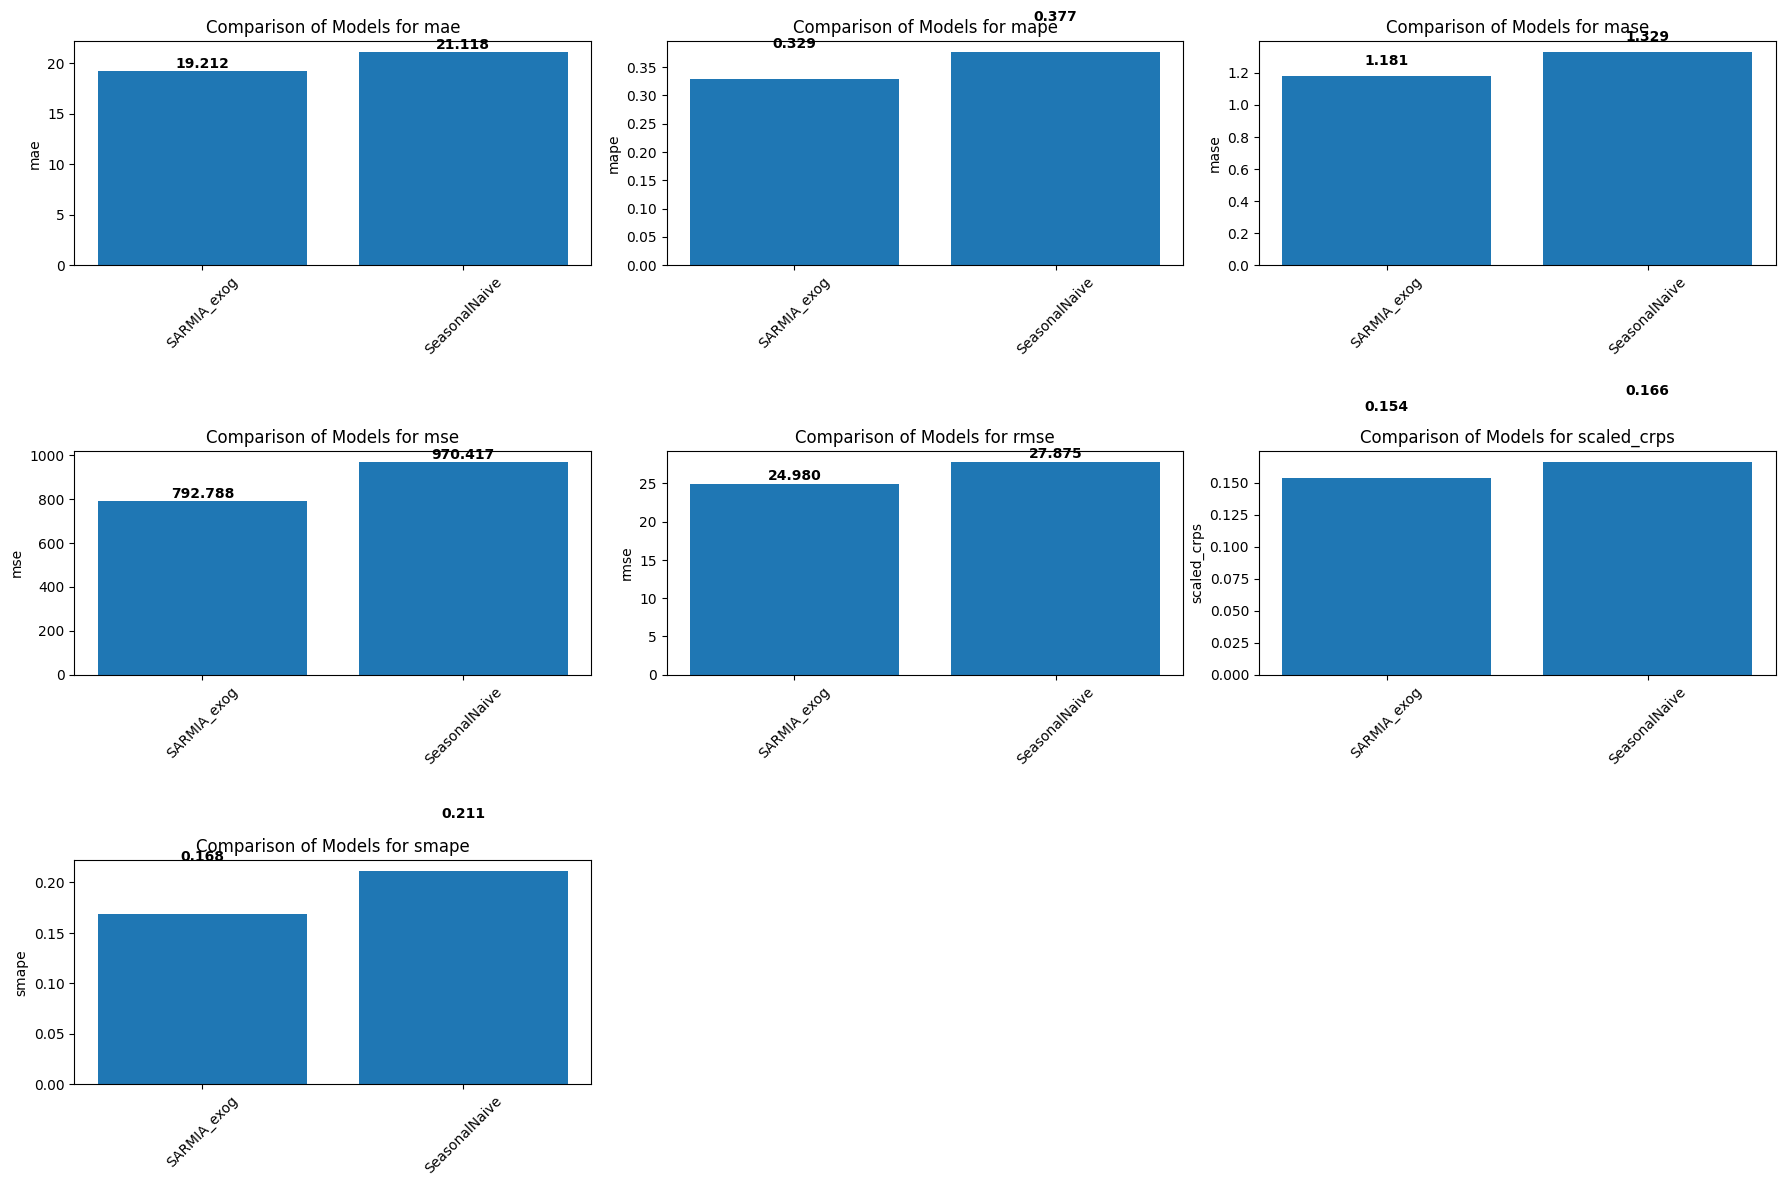

In [81]:
fig , axes = plt.subplots(3 , 3 , figsize=(18 , 12))
axes_flat = axes.flatten()

models = ['SARMIA_exog' , 'SeasonalNaive']
x_pos = [0 , 1]

for i, metric in enumerate(final_eval['metric']):
    ax = axes_flat[i]
    values = final_eval[final_eval['metric'] == metric].iloc[0, 1:].tolist()
    bars = ax.bar(models, values)
    ax.set_ylabel(metric)
    ax.set_title(f'Comparison of Models for {metric}')
    ax.tick_params(axis='x', rotation=45)

    for bar, value in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05,
                f'{value:.3f}', va='bottom', ha='center', fontweight='bold')

for j in range(i + 1, len(axes_flat)):
    fig.delaxes(axes_flat[j])

plt.tight_layout()
plt.show()